In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial.transform import Rotation as r
from scipy.optimize import curve_fit

In [2]:
def sph2cart(phi, theta, T):
    """ Convert from spherical/polar (phi, thetha) to cartesian
    coordinates.

    Parameters
    ----------
    phi : int or float between 0 and 90
        angle respect to the c-axis
    theta : int or float between 0 and 360
        angle respect to the a-axis
    T : int or float
        the magnitud of the vector (rho) in polar coordinates

    Returns
    -------
    numpy ndarrays (1d)
        three numpy 1d arrays with the x, y, and z coordinates
    """
    
    x = T * np.sin(phi) * np.cos(theta)
    y = T * np.sin(phi) * np.sin(theta)
    z = T * np.cos(phi)
    
    return x, y, z


def Tvalues(trans, phi, theta):
    """ Calculates the transmission value for any direction in polar
    coordinates using the equation (5) in Asimov et al. (2006).

    Parameters
    ----------
    trans : a tuple of size 3
        tuple containeing the transmission values along a-axis (Ta),
        b-axis (Tb), and c-axis (Tc). -> (Ta, Tb, Tc)
    phi : int or float between 0 and 90
        angle respect to the c-axis
    theta : int or float between 0 and 360
        angle respect to the a-axis

    Returns
    -------
    numpy array
        the calculated T values for any given orientation
    """

    # extract Tx values
    Ta, Tb, Tc = trans
    
    return Ta * np.cos(theta)**2 * np.sin(phi)**2 + \
           Tb * np.sin(theta)**2 * np.sin(phi)**2 + \
           Tc * np.cos(phi)**2


> **Caution note**: if we create a uniform dataset for theta and phi, the dataset generated will not be uniformly distributed because of the polar coordinates.
> See https://mathworld.wolfram.com/SpherePointPicking.html or  
> http://corysimon.github.io/articles/uniformdistn-on-sphere/

(Text(0.5, 0, '$x$'), Text(0.5, 0.5, '$y$'), Text(0.5, 0, '$z$'))

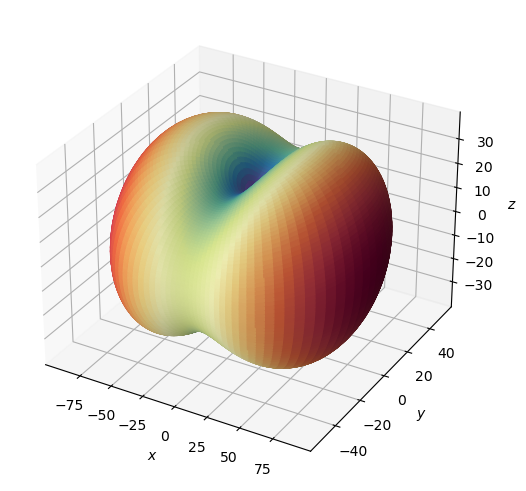

In [3]:
# generate spherical/polar coordinates
theta = np.linspace(0, 2*np.pi, 100)
phi = np.arccos(1 - 2 * np.linspace(0, 1, 100))  # in this case np.linspace goes from 0 to 1 (not pi)!
phi, theta = np.meshgrid(phi, theta)

# estimate T values
T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

# convert from spherical to cartesian coordinates
x, y, z = sph2cart(phi, theta, T)

# normalize colors for T values to max and min values
Tmax, Tmin = T.max(), T.min()
Tcolors = (T - Tmin) / (Tmax - Tmin)

# make figure
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)

ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')

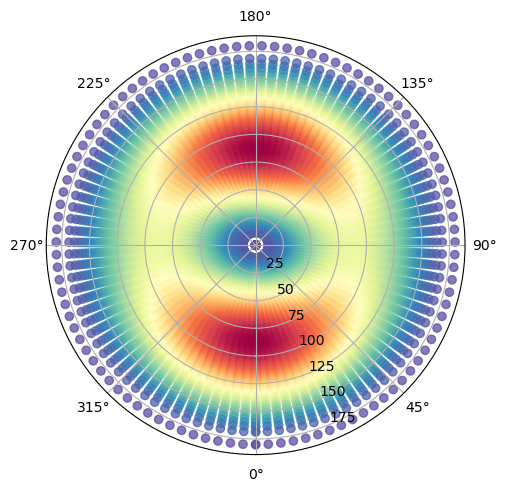

In [4]:
# make polar scatter figure, colors represent T values
# make figure
fig2, ax = plt.subplots(subplot_kw={"projection": "polar"}, constrained_layout=True)

# locate theta origin south as in the figure 1 of Asimov et al. (2006)
ax.set_theta_zero_location('S')

# plot the data (for phi I converted radians to degrees)
_ = ax.scatter(theta, np.rad2deg(phi), c=T, cmap='Spectral_r', alpha=0.75)

In [5]:
def rotate(coordinates, euler_ang):
    """_summary_

    Parameters
    ----------
    coordinates : tuple of size 3
        a tuple containing the cartesian coordinates of tis form:
        (x, y, z). variables x, y and cand be scalars or arrays.
    euler_ang : tuple of size 3
        a tuple containing the three euler angles in degrees
        using Bunge convention -> (z, x, z)

    Returns
    -------
    three numpy arrays containing the x, y, z coordinates respectively
    
    Example
    -------
    x, y, z = rotate(coordinates=(x, y, z), euler_ang=(30, 0, 40))
    """
    # create a ndarray to vectorize the rotation operation
    coordinates = np.dstack(coordinates)

    # define a rotation in euler space (Bunge)
    rotation = r.from_euler('zxz', [euler_ang[0], euler_ang[1], euler_ang[2]], degrees=True)

    # apply rotation
    new_coordinates = coordinates @ rotation.as_matrix().T

    return new_coordinates[:,:,0], new_coordinates[:,:,1], new_coordinates[:,:,2]

In [6]:
rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(30, 45, 60))

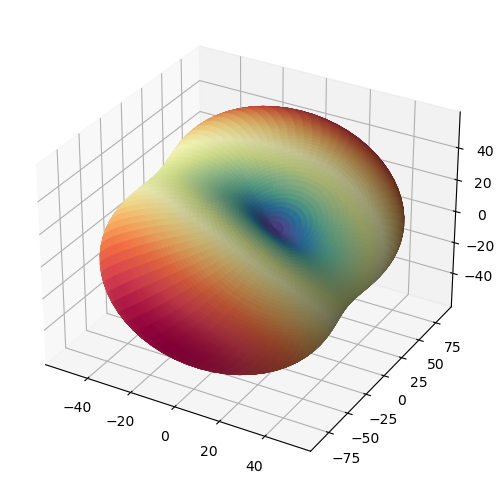

In [7]:
# check making a plot
fig2, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
ax.plot_surface(rot_x, rot_y, rot_z, rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))

# Generate a toy dataset to test

In [8]:
# generate random spherical/polar coordinates (just 5x5=25)
np.random.seed(218)  # this is just for reproducibility (generates random number based on seed. Seed can be any number), comment if you want to generate different toy datasets
phi = np.arccos(1 - 2 * np.random.uniform(low=0, high=1, size=5))
theta = np.random.uniform(low=0, high=2*np.pi, size=5)
phi, theta = np.meshgrid(phi, theta)

# estimate T values
T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

# convert from spherical to cartesian coordinates
x, y, z = sph2cart(phi, theta, T)

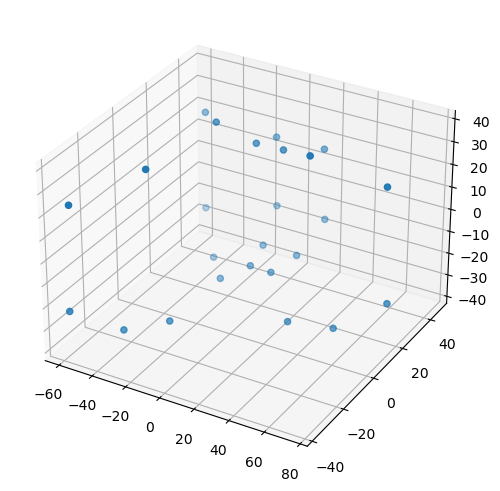

In [9]:
# check making a plot
fig3, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
ax.scatter(x, y, z)

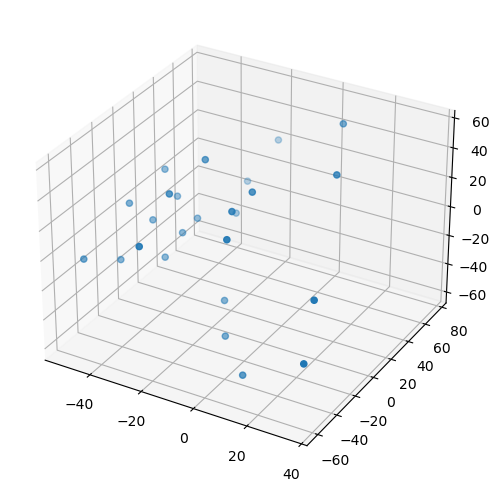

In [10]:
rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(30, 45, 60))

# check making a plot
fig4, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
ax.scatter(rot_x, rot_y, rot_z)

# Fitting test using the curve_fit procedure

The routine ``curve_fit`` works as follow

- the first argument is the function to minimize
- the second argument is the independ data (for convenience the coordinates of the points for when euler angles are (0,0,0))
- the second argument is the dependent data (the transformed/rotated coordinates)
- the fourth argument is the initial guess of the different parameters

TODO

$$
y = x \times R
$$

where
- $y$ is the $(x,y,z)$ coordinates of the rotated data (what we measure),
- $x$ is the $(x,y,z)$ coordinates of the unrotated data, and
- $R$ the matrix rotation estimated from the Euler angles.

In [11]:
def func(ref_coordinates, a, b, c):
    """_summary_

    Parameters
    ----------
    xdata : _type_
        _description_
    a : _type_
        _description_
    b : _type_
        _description_
    c : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """

    # temporary solution (flattened input) -> reshape
    dim = int(np.sqrt(len(ref_coordinates) / 3))
    ref_coordinates = ref_coordinates.reshape(dim, dim, 3)
    
    # define a rotation in euler space (Bunge)
    rotation = r.from_euler('zxz', [a, b, c], degrees=True)

    # apply rotation
    guess_coordinates = ref_coordinates @ rotation.as_matrix().T

    return guess_coordinates.flatten()

In [12]:
# this will not be necessary once the refactoring is done
ref_coordinates = np.dstack((x, y, z))
rot_coordinates = np.dstack((rot_x, rot_y, rot_z))

ok, so the error in previous attempts was that ``curve_fit()`` and thus ``least_squares()`` expect that the function returns a 1-d array, i.e. of shape ``(n,)``. We need to flatten/ravel de n-d arrays that represents the indepent and dependent data into 1-d arrays to make it work.

In [13]:
# test curve_fit
popt, pcov = curve_fit(func,
                       xdata=ref_coordinates.flatten(),      # independent data (array flattened)
                       ydata=rot_coordinates.flatten(),      # dependent data (array flattened)
                       p0=(90, 90, 90),                      # initial guess for euler angles (it didn't work when using (0,0,0))
                       bounds=((0, 0, 0), (180, 180, 180)))  # orthorhombic symmetry such as olivine euler angles vary between 0 and 180 (0 and pi in radians)

In [14]:
# plot the solution
popt

array([30., 45., 60.])

Voila, the exact result so it works. TODO -> think how to organise everything better taking into account the shape of the inpus!

In [15]:
# standard deviation
np.sqrt(np.diag(pcov))

array([7.39058706e-15, 5.35716670e-15, 7.69427840e-15])